In [1]:
# This is a Python 3 environment

# Base level imports for data science work
import numpy as np 
import pandas as pd
import re,string,unicodedata
import os
from os import path
from json import decoder
import glob, os, json
import re

# Visualization Libs
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# NLP Libs
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
from keras.preprocessing import text, sequence
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Additional Libs
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

# Deep Learning Libs
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [2]:
# Mounting Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#cd /content/drive/MyDrive/BA/0.4/Sources/

# Start der Datenverarbeitung

In [4]:
fangcovid = pd.read_csv("https://chruezfalsch.ch/df_FANG-COVID.csv")
#Herunterladen des Data Frame
df_ba = pd.read_csv("https://chruezfalsch.ch/df_ba.csv")
del df_ba['Unnamed: 0'] 

df_fangcovid = pd.DataFrame()
fangcovid.label = fangcovid.label.map({ 'fake' : 1, 'real' : 0})
df_fangcovid['fake'] = fangcovid['label']
del fangcovid['label']
df_fangcovid['text'] =  fangcovid['header'] + fangcovid['article']
del fangcovid['article']
del fangcovid['header']
del fangcovid['twitter-history']
df_fangcovid['url'] = fangcovid['url']
df_fangcovid['source'] = fangcovid['source']
del fangcovid
df=df_fangcovid
del df_fangcovid

In [5]:
df = df[df['text'].str.split().str.len().gt(400)]
df = df[df['text'].str.split().str.len().lt(3500)]
df_ba = df_ba[df_ba['text'].str.split().str.len().gt(400)]
df_ba = df_ba[df_ba['text'].str.split().str.len().lt(3500)]

In [6]:
#Kontrolle DF_BA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


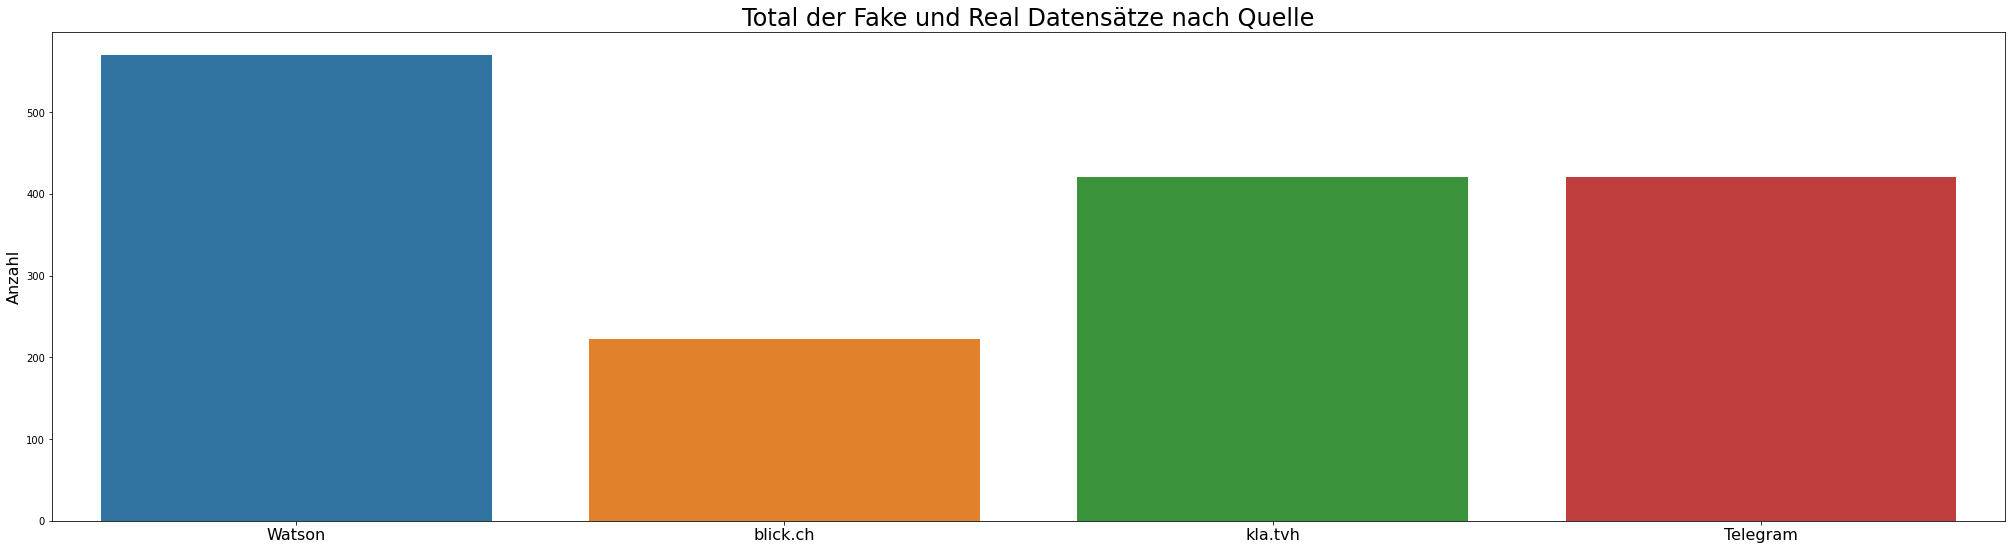

In [7]:
#Ploten der Verteilung der Datensätze nach Quellen
plt.figure(figsize=(35,9))

sns.countplot(df_ba.source)
plt.title('Total der Fake und Real Datensätze nach Quelle', fontsize=24)
plt.ylabel('Anzahl', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=16)

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


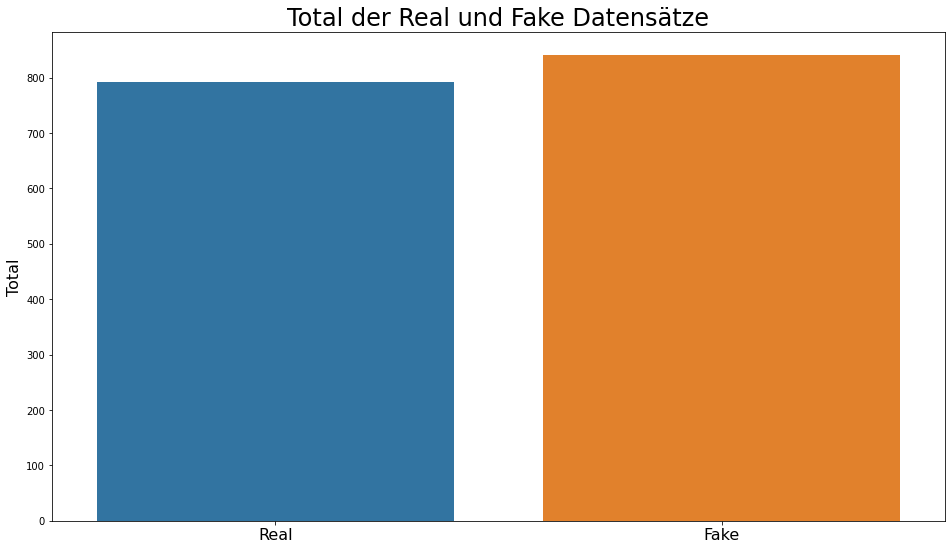

In [8]:
#Aufteilung Fake und Real News
plt.figure(figsize=(16,9))

sns.countplot(df_ba.fake)
plt.title('Total der Real und Fake Datensätze', fontsize=24)
plt.ylabel('Total', fontsize=16)
plt.xlabel('')
plt.xticks([0,1], ['Real','Fake'], fontsize=16)
plt.xticks(fontsize=16)

plt.show()

Kontrolle FANG-COIVID

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


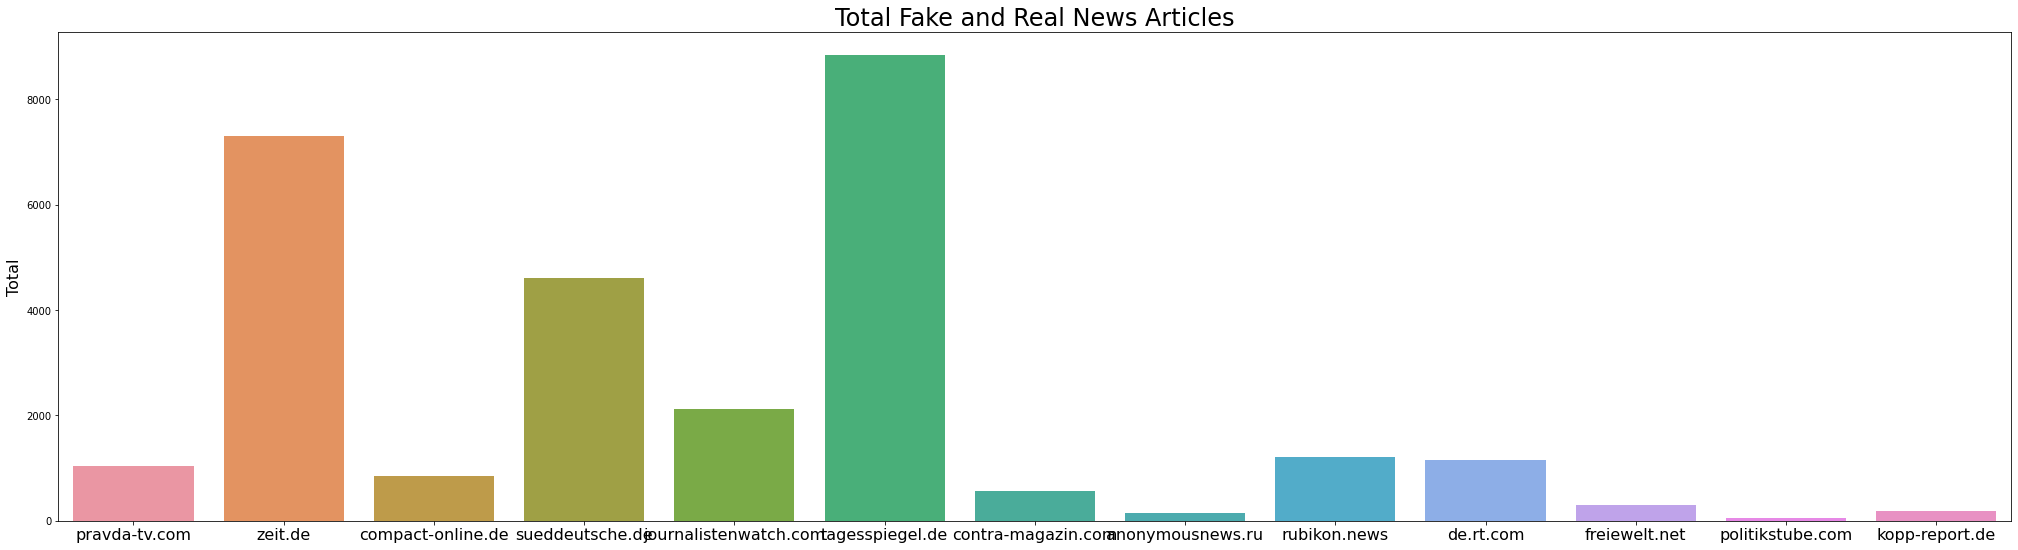

In [9]:
plt.figure(figsize=(35,9))

sns.countplot(df.source)
plt.title('Total Fake and Real News Articles', fontsize=24)
plt.ylabel('Total', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=16)

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


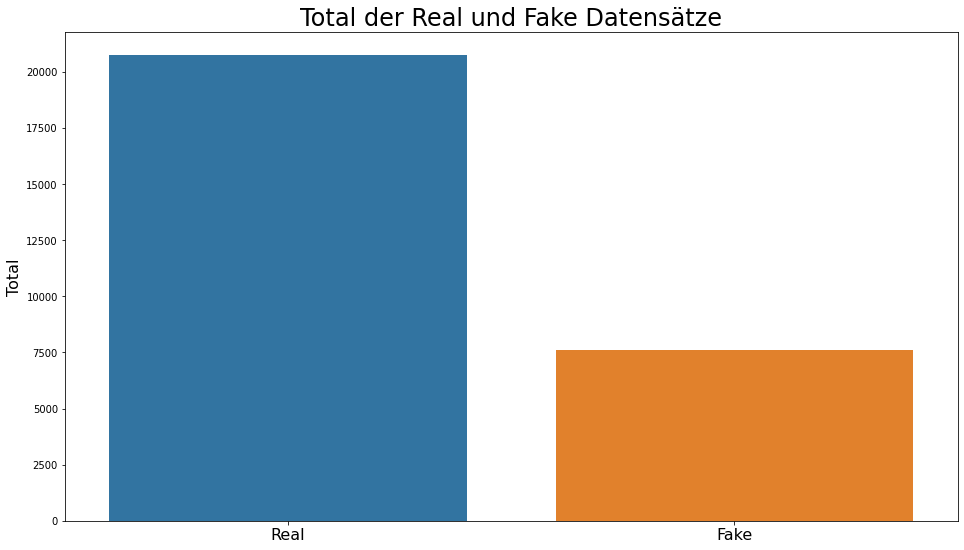

In [10]:
#Aufteilung Fake und Real News
plt.figure(figsize=(16,9))

sns.countplot(df.fake)
plt.title('Total der Real und Fake Datensätze', fontsize=24)
plt.ylabel('Total', fontsize=16)
plt.xlabel('')
plt.xticks([0,1], ['Real','Fake'], fontsize=16)
plt.xticks(fontsize=16)

plt.show()

In [11]:
import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
stop = set(stopwords.words('german'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
def removeurls(text):
  return re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
def removeklatv(text):
  return re.sub("(?i)kla.tv:","Quelle", text)
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

# Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
def wordstem(text):
    stemmer = SnowballStemmer("german")
    final_text = []
    for i in text.split():
      word=""
      for z in i:
        if z.isalpha():
          word=word+z
        else:
          if word !="":
            stemed=stemmer.stem(word)
            if stemed == "":
                stemed=word
            final_text.append(stemed)
            #print(word, "/", stemed)
          word=""
          final_text.append(z)
          #final_text.append(stemmer.stem(i.strip()))
        final_text.append(" ")
    return "".join(final_text)
# Final function to clean the text
def clean_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_urls(text)
    text = remove_stopwords(text)
    #text = wordstem(text)
    return text

In [13]:
#Quellen Entfernen
df_ba['text']=df_ba['text'].replace("kla.tv", "Quelle")
df_ba['text']=df_ba['text'].replace("KLA.TV", "Quelle")
df_ba['text']=df_ba['text'].replace("KLA.TV:", "Quelle")
df_ba['text']=df_ba['text'].replace("Kla.TV:", "Quelle")
df_ba['text']=df_ba['text'].replace("Kla.TV", "Quelle")
df_ba['text']=df_ba['text'].replace("blick.ch", "Quelle")
df_ba['text']=df_ba['text'].replace("watson.ch", "Quelle")
df_ba['text']=df_ba['text'].replace("watson", "Quelle")
df_ba['text']=df_ba['text'].replace("Zeit Online", "Quelle")
df_ba['text']=df_ba['text'].replace("Zeit online", "Quelle")
df_ba['text']=df_ba['text'].replace("zeit online", "Quelle")
df_ba['text']=df_ba['text'].replace("(...)", "")
df_ba['text']=df_ba['text'].replace("...", ".")
df_ba['text']=df_ba['text'].replace("!!!", "!")
df_ba['text']=df_ba['text'].replace("???", "?")
df_ba['text']=df_ba['text'].replace("ß", "ss")

#Quellen Entfernen
df['text']=df['text'].replace("kla.tv", "Quelle")
df['text']=df['text'].replace("KLA.TV", "Quelle")
df['text']=df['text'].replace("KLA.TV:", "Quelle")
df['text']=df['text'].replace("Kla.TV:", "Quelle")
df['text']=df['text'].replace("Kla.TV", "Quelle")
df['text']=df['text'].replace("blick.ch", "Quelle")
df['text']=df['text'].replace("watson.ch", "Quelle")
df['text']=df['text'].replace("watson", "Quelle")
df['text']=df['text'].replace("Zeit Online", "Quelle")
df['text']=df['text'].replace("Zeit online", "Quelle")
df['text']=df['text'].replace("zeit online", "Quelle")
df['text']=df['text'].replace("(...)", "")
df['text']=df['text'].replace("...", ".")
df['text']=df['text'].replace("!!!", "!")
df['text']=df['text'].replace("???", "?")
df['text']=df['text'].replace("ß", "ss")

In [14]:
df['text']=df['text'].apply(removeurls)
df['text']=df['text'].apply(removeklatv)
df['text']=df['text'].apply(remove_emojis)
df['text']=df['text'].apply(clean_text)

df_ba['text']=df_ba['text'].apply(removeurls)
df_ba['text']=df_ba['text'].apply(removeklatv)
df_ba['text']=df_ba['text'].apply(remove_emojis)
df_ba['text']=df_ba['text'].apply(clean_text)

In [15]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
cd /content/drive/MyDrive/BA/Project/

/content/drive/MyDrive/BA/Project


In [17]:
df.to_csv('df_FANG-COVID_cleaned_400-3500.csv')
!cp 'df_FANG-COVID_cleaned_400-3500.csv' "/content/drive/MyDrive/BA/Project/df_FANG-COVID_cleaned_400-3500.csv"
df_ba.to_csv('df_BA_cleaned_400-3500.csv')
!cp 'df_BA_cleaned_400-3500.csv' "/content/drive/MyDrive/BA/Project/df_BA_cleaned_400-3500.csv"

cp: 'df_FANG-COVID_cleaned_400-3500.csv' and '/content/drive/MyDrive/BA/Project/df_FANG-COVID_cleaned_400-3500.csv' are the same file
cp: 'df_BA_cleaned_400-3500.csv' and '/content/drive/MyDrive/BA/Project/df_BA_cleaned_400-3500.csv' are the same file


In [18]:
# Export ohne anpassung der Länge
#df.to_csv('df_FANG-COVID_cleaned_all_LEN.csv')
#!cp df_FANG-COVID_cleaned_all_LEN.csv "/content/drive/MyDrive/BA/Project/df_FANG-COVID_cleaned_all_LEN.csv"